In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
import cv2
from scipy.ndimage import sobel
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

# Custom loss functions
from metrics import log_dice_loss, dice_coef, iou  


In [22]:
image_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/cusp_images"
mask_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/masks"
# Path to previously trained model
pretrained_model_path = "/Users/rfalcao/FYP/BC50Tuned2.h5"  # Change to actual path

# Load the model with custom metrics
model = load_model(pretrained_model_path, custom_objects={'dice_coef': dice_coef, 'iou': iou})
IMG_SIZE = 224


# Compile with a lower learning rate for gradual fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['binary_accuracy', dice_coef, iou])



In [23]:


# Helper to normalize a vector
def normalize(v):
    return v / np.linalg.norm(v)
def compute_sobel_magnitude(gray_img):
    dx = sobel(gray_img, axis=1)
    dy = sobel(gray_img, axis=0)
    magnitude = np.hypot(dx, dy)
    return magnitude
def trace_contrast_direction(center, perp_unit_vector, sobel_mag, max_radius=30, threshold=20):
    center = np.array(center)
    best_grad = [0, 0]
    directions = [+1, -1]

    for idx, direction_sign in enumerate(directions):
        for r in range(1, max_radius):
            offset = direction_sign * r * perp_unit_vector
            sample_pt = np.round(center + offset).astype(int)

            x, y = sample_pt
            if y < 0 or y >= sobel_mag.shape[0] or x < 0 or x >= sobel_mag.shape[1]:
                break

            grad_value = sobel_mag[y, x]
            if grad_value > best_grad[idx]:
                best_grad[idx] = grad_value

            if grad_value > threshold:
                break

    confidence = max(best_grad)
    
    chosen_direction = perp_unit_vector if best_grad[0] >= best_grad[1] else -perp_unit_vector
    return chosen_direction, confidence



In [26]:
from skimage.color import rgb2gray
def predict_mask(image_path):
    """
    Loads an image, resizes it to model input size, predicts the mask,
    then resizes the mask back to the original image size.
    """
    # Load original image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_shape = img.shape[:2]  # (H, W)

    # Resize for model input
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_input = img_resized.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_input, axis=(0, -1))  # shape: (1, 224, 224, 1)

    # Predict
    pred = model.predict(img_input)[0, ..., 0]  # shape: (224, 224)
    pred_resized = cv2.resize(pred, (original_shape[1], original_shape[0]))  # Resize to original W×H
    pred_mask = (pred_resized > 0.5).astype(np.uint8)  # Binary mask

    return pred_mask, img  # Return original (grayscale) image for reference


# Cell 4: Process prediction with PCA
def process_prediction(image_path, pred_mask):
    
    image = np.array(Image.open(image_path).convert("RGB"))
    gray_img = rgb2gray(image) * 255
    sobel_mag = compute_sobel_magnitude(gray_img)

    num_labels, labels = cv2.connectedComponents(pred_mask)
    results = []

    for i in range(1, num_labels):
        component_mask = (labels == i).astype(np.uint8)
        y_idxs, x_idxs = np.nonzero(component_mask)
        coords = np.stack((x_idxs, y_idxs), axis=1)

        if coords.shape[0] < 2:
            continue

        pca = PCA(n_components=2)
        pca.fit(coords)
        direction = pca.components_[0]
        center = pca.mean_
        projections = coords @ direction
        tip_coord = coords[np.argmax(projections)]
        base_coord = coords[np.argmin(projections)]

    # Perpendicular unit vector
        perp = np.array([-direction[1], direction[0]])
        perp_unit = perp / np.linalg.norm(perp)

        # Trace sharp edge direction
        sharp_edge_vector, confidence = trace_contrast_direction(center, perp_unit, sobel_mag)


        result = {
        "image_name": image_path.split("/")[-1],
        "label_id": i,
        "image": image,
        "component_mask": component_mask,
        "coords": coords,
        "centerline": (base_coord, tip_coord),
        "center": center,
        "pca_direction": direction,
        "sharp_edge_vector": sharp_edge_vector,
        "confidence": confidence
}
        results.append(result)

    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


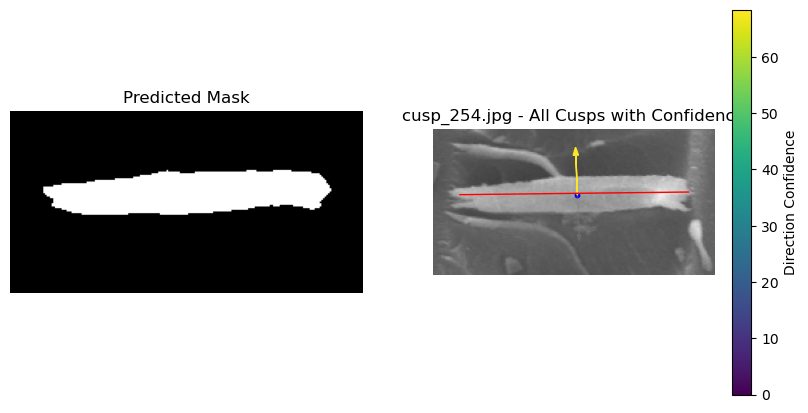

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


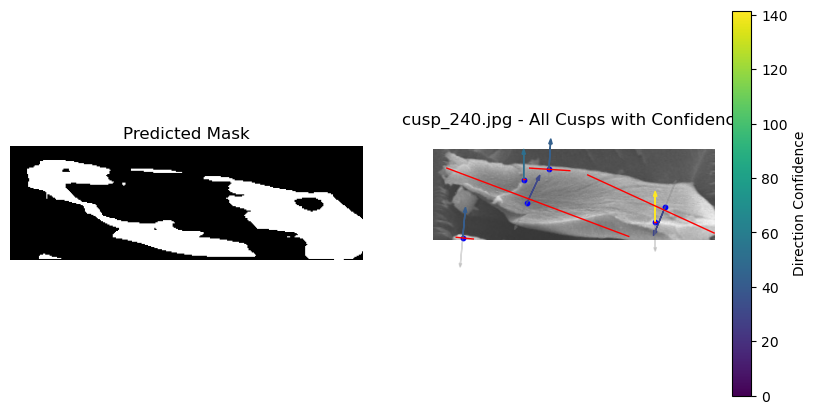

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


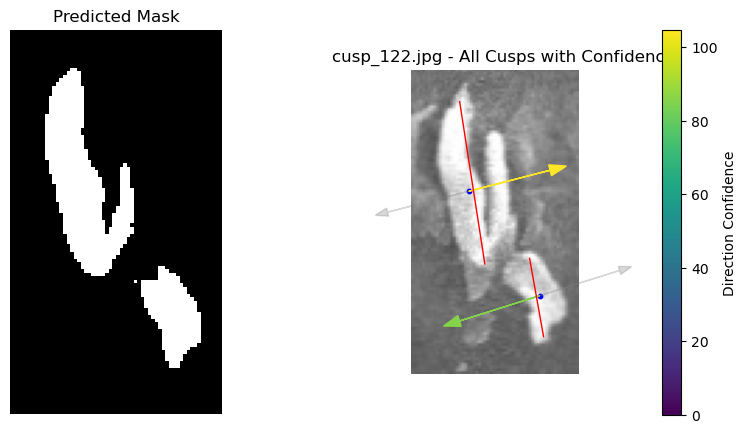

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


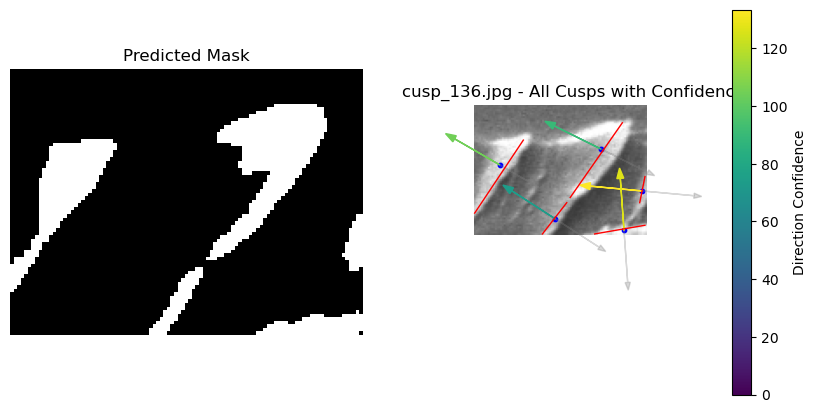

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


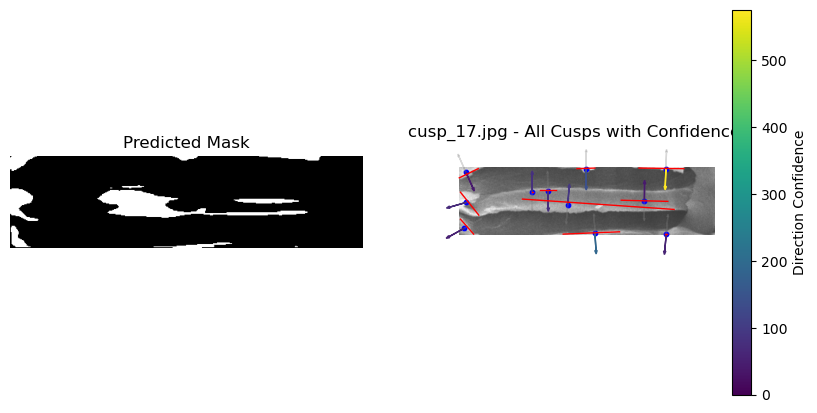

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


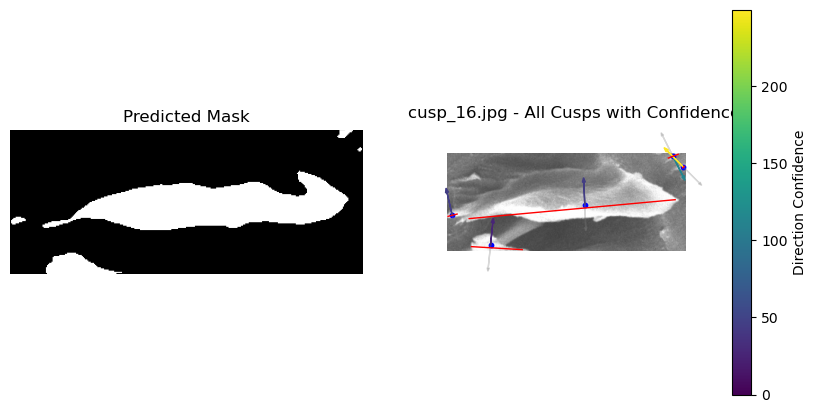

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


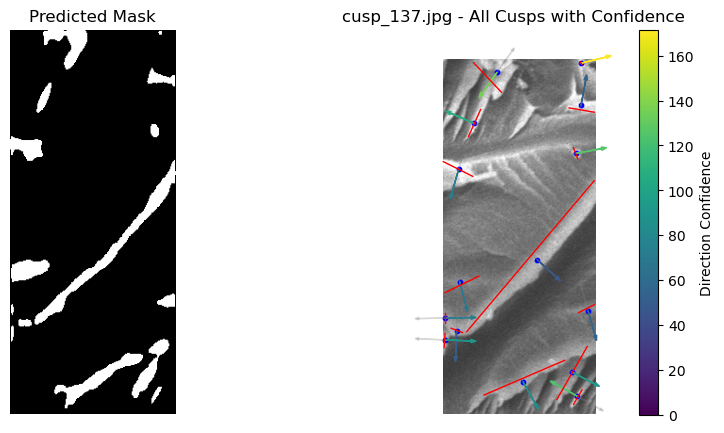

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


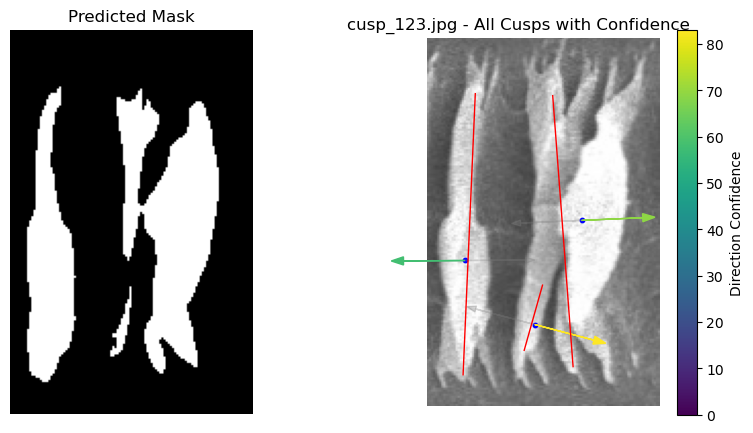

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


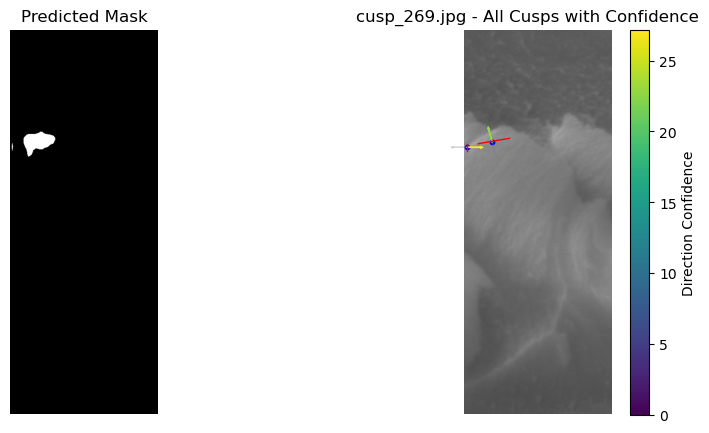

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


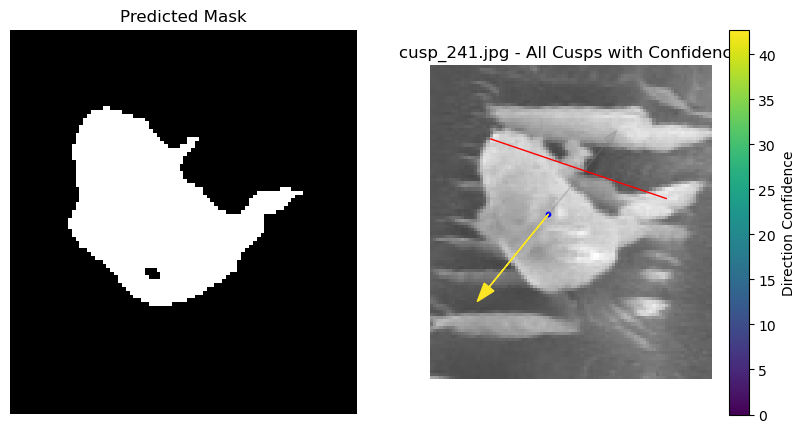

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


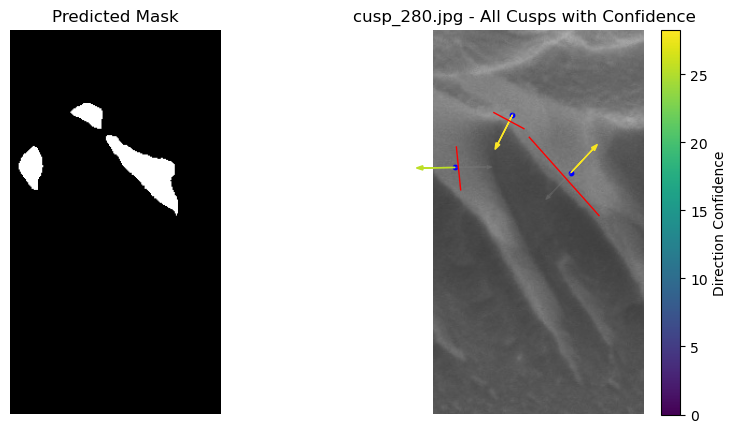

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


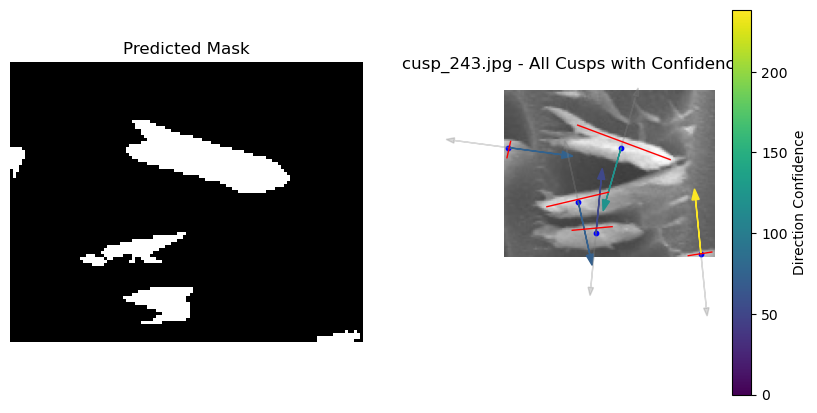

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


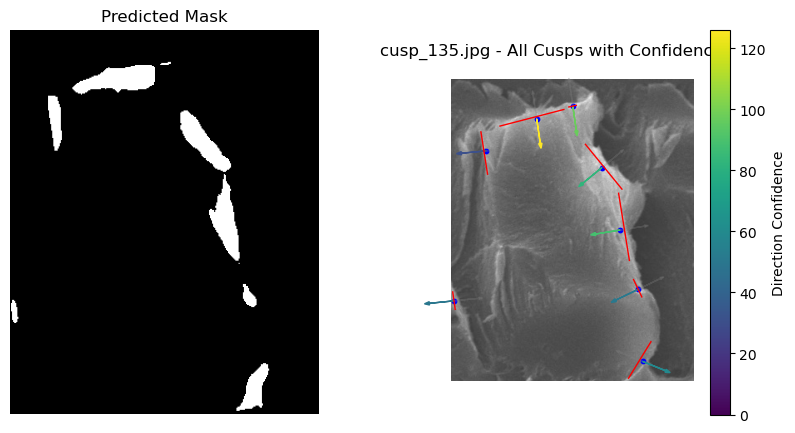

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


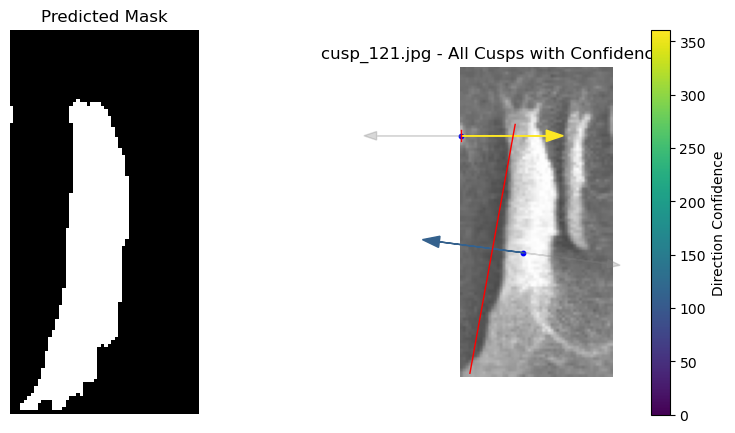

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


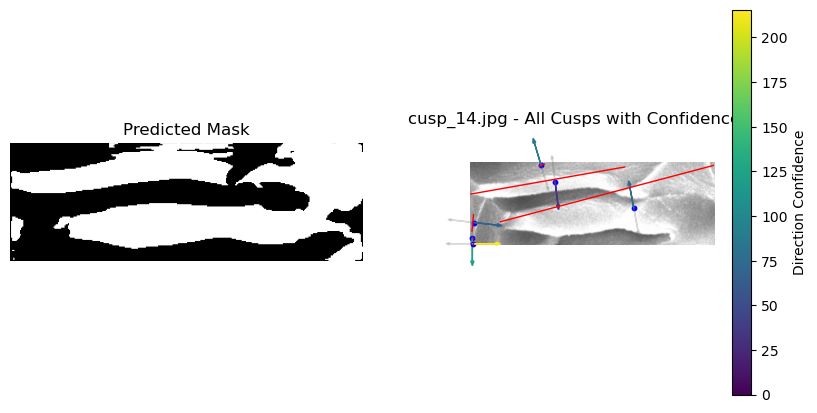

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


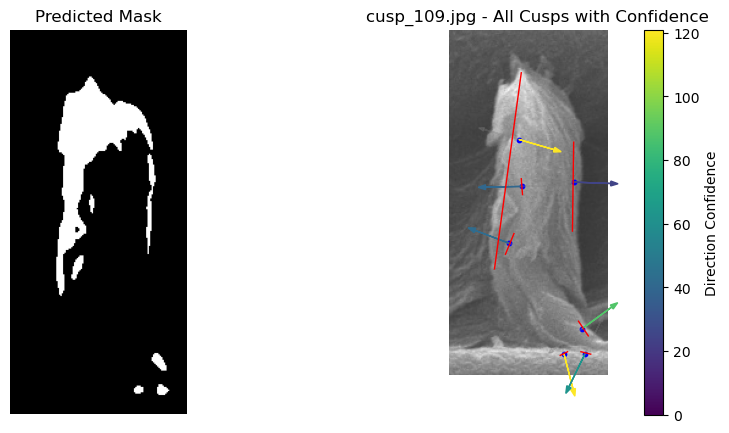

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


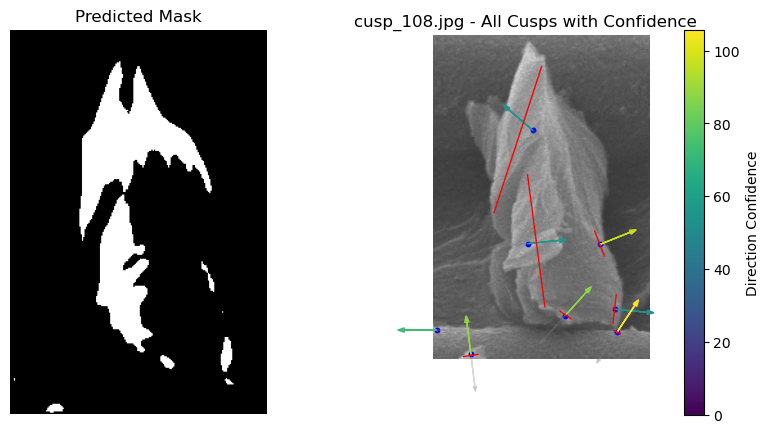

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


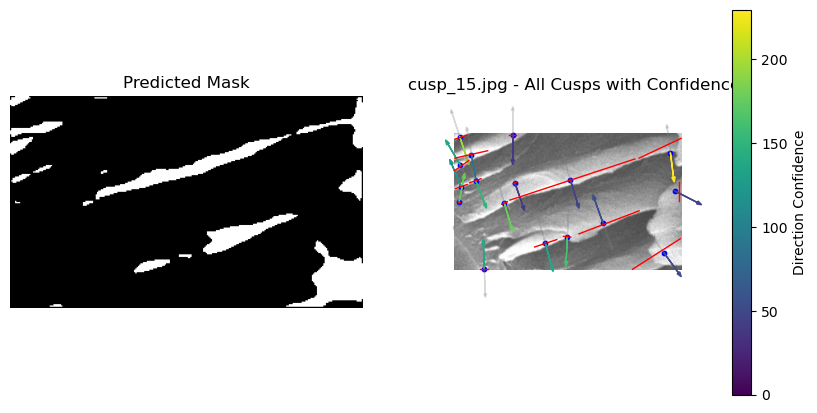

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


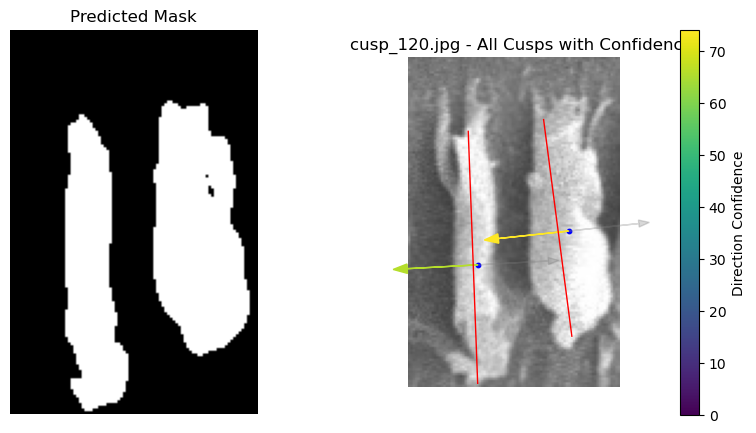

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


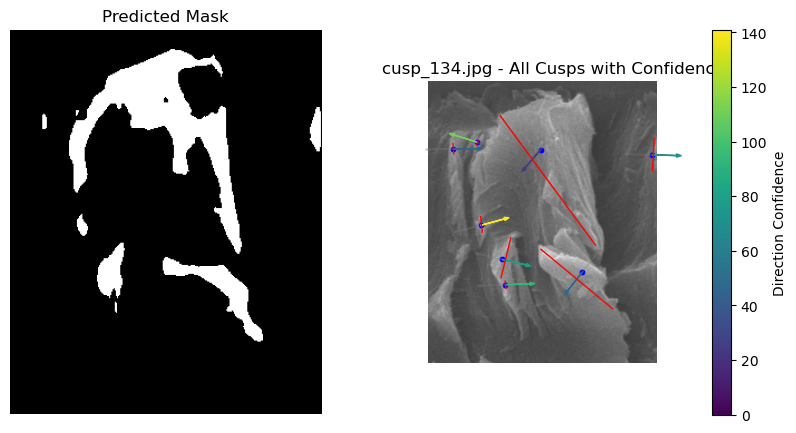

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


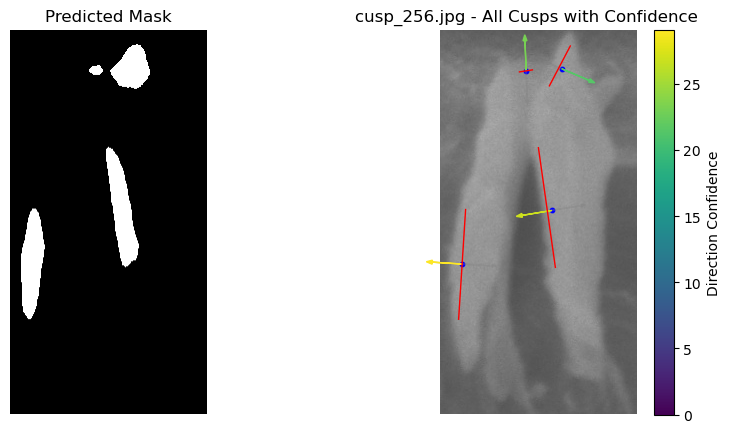

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


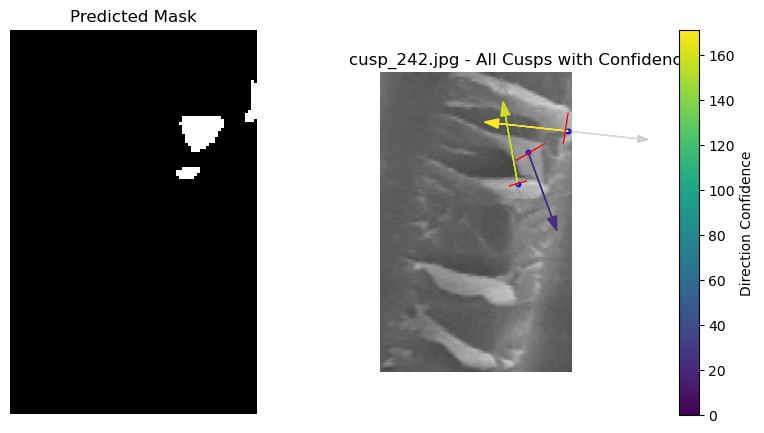

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


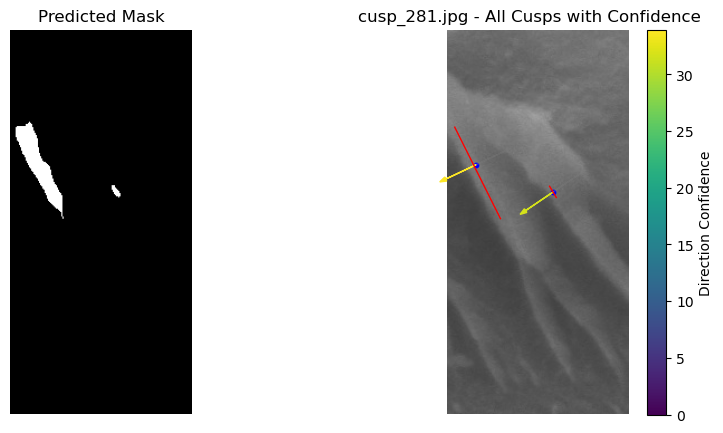

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


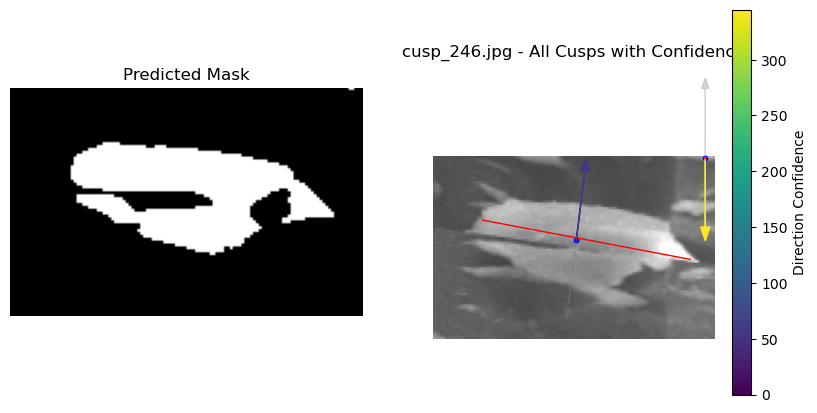

AttributeError: 'NoneType' object has no attribute 'shape'

In [28]:
import matplotlib.cm as cm

for fname in os.listdir(image_dir):
    image_path = os.path.join(image_dir, fname)
    pred_mask, original_img = predict_mask(image_path)
    results = process_prediction(image_path, pred_mask)

    if not results:
        continue

    # Get confidence range for this image
    confidences = [sample["confidence"] for sample in results]
    max_conf = max(confidences) if confidences else 1e-6

    # Plot all detected cusps in the same image
    plt.figure(figsize=(10, 5))

    # Subplot 1: Predicted Mask
    plt.subplot(1, 2, 1)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Subplot 2: Original image with all vectors
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(results[0]["image"])
    scale_length = 30

    for sample in results:
        base, tip = sample["centerline"]
        center = sample["center"]
        sharp_vec = sample["sharp_edge_vector"]
        v = sample["pca_direction"]
        u = np.array([-v[1], v[0]]) / np.linalg.norm([-v[1], v[0]])
        confidence = sample["confidence"]
        norm_conf = confidence / max_conf
        color = cm.viridis(norm_conf)  # Maps confidence to color

        # Draw PCA centerline
        ax2.plot([base[0], tip[0]], [base[1], tip[1]], 'r-', linewidth=1)
        ax2.scatter(center[0], center[1], color='blue', s=10)

        # Optional: perpendiculars (gray)
        for sign in [+1, -1]:
            vec = sign * u * scale_length
            ax2.arrow(center[0], center[1], vec[0], vec[1], head_width=3, color='gray', alpha=0.3)

        # Final vector: confidence-colored
        final_vec = sharp_vec * scale_length
        ax2.arrow(center[0], center[1], final_vec[0], final_vec[1], head_width=4, color=color)

    # Add colorbar to right subplot
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max_conf))
    plt.colorbar(sm, ax=ax2, label='Direction Confidence')

    plt.title(f"{fname} - All Cusps with Confidence")
    plt.axis('off')
    plt.show()


In [29]:
def refine_masks(pred, thresholds=[0.3, 0.4, 0.5, 0.6]):
    refined_masks = {}

    # Gaussian blur
    blurred = cv2.GaussianBlur(pred, (3, 3), 0)

    for t in thresholds:
        binary = (pred > t).astype(np.uint8)
        blurred_binary = (blurred > t).astype(np.uint8)

        # Morph operations
        kernel = np.ones((3, 3), np.uint8)
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

        refined_masks[f"threshold_{t}"] = binary
        refined_masks[f"blurred_thresh_{t}"] = blurred_binary
        refined_masks[f"opened_thresh_{t}"] = opened
        refined_masks[f"closed_thresh_{t}"] = closed

    return refined_masks


In [30]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load and preprocess image
def predict_soft_mask(image_path, model, img_size=224):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    original_shape = img.shape[:2]
    img_resized = cv2.resize(img, (img_size, img_size))
    img_input = img_resized.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_input, axis=(0, -1))  # Shape: (1, 224, 224, 1)

    # Predict
    pred = model.predict(img_input)[0, ..., 0]  # Shape: (224, 224)
    pred_resized = cv2.resize(pred, (original_shape[1], original_shape[0]))  # Resize to original shape

    return pred_resized  # Soft mask, values between 0 and 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


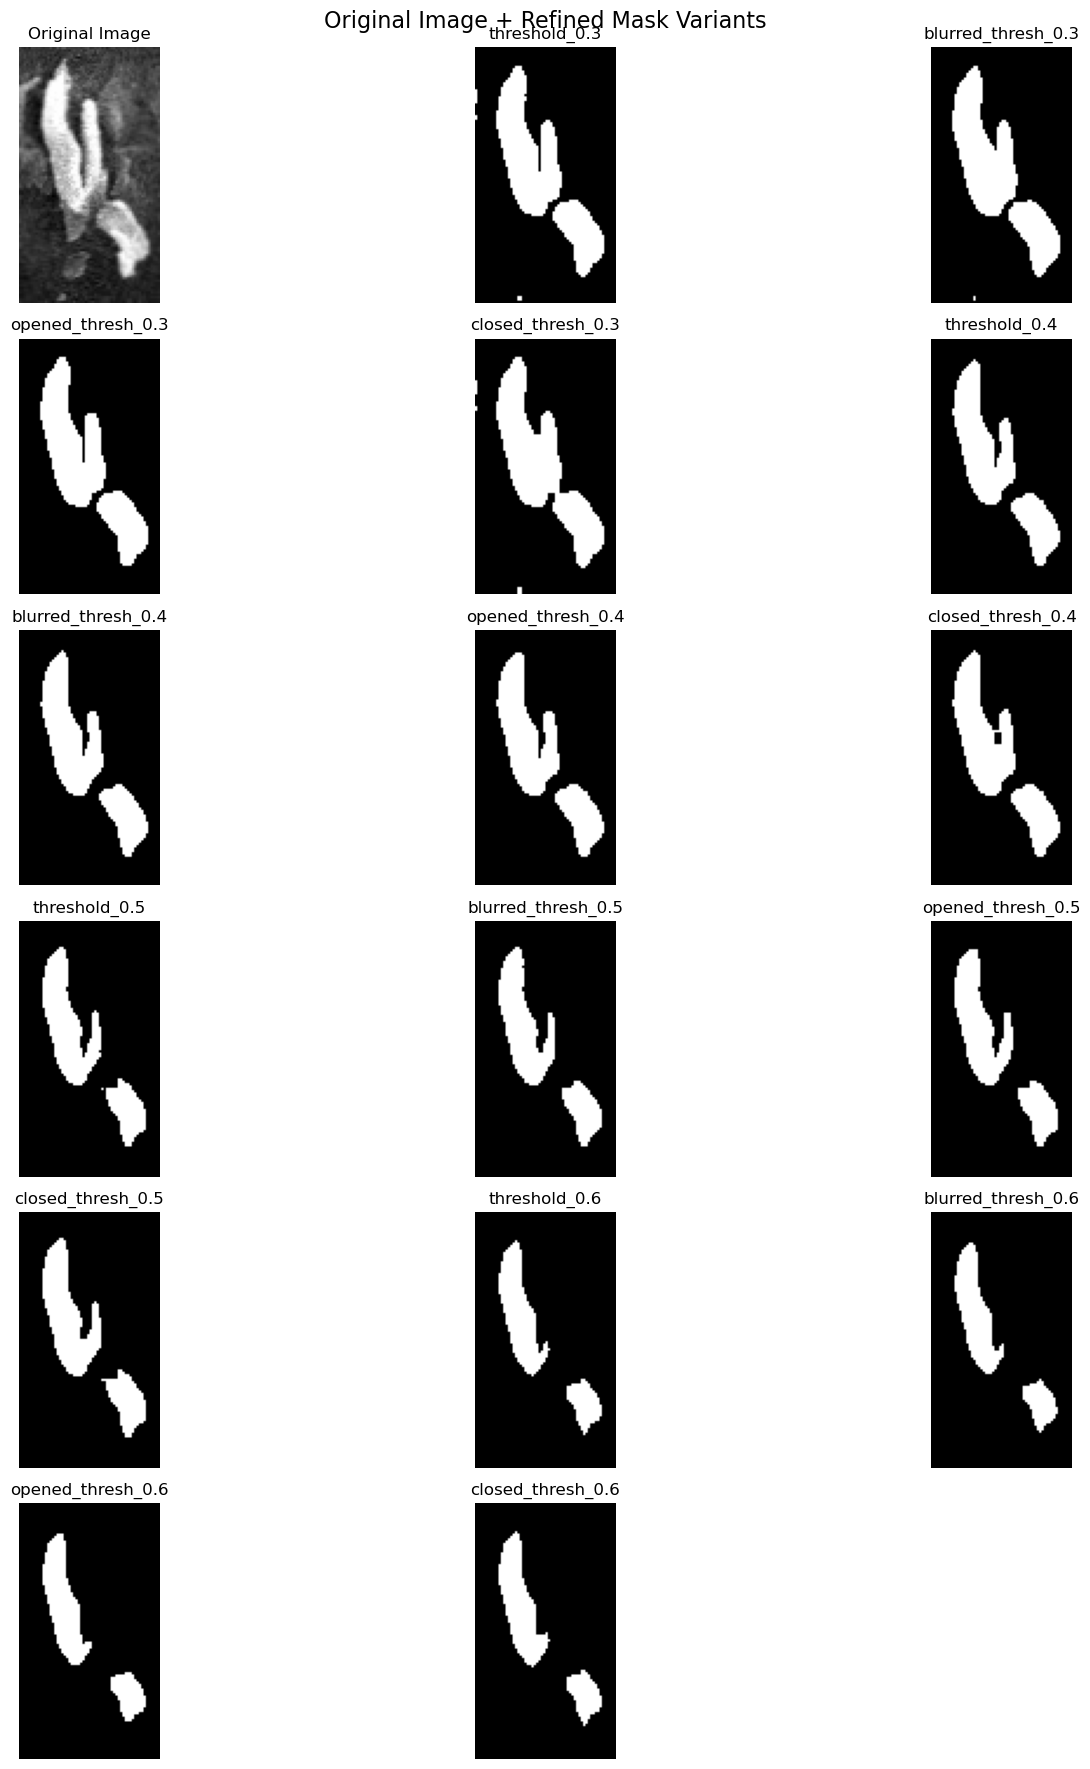

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


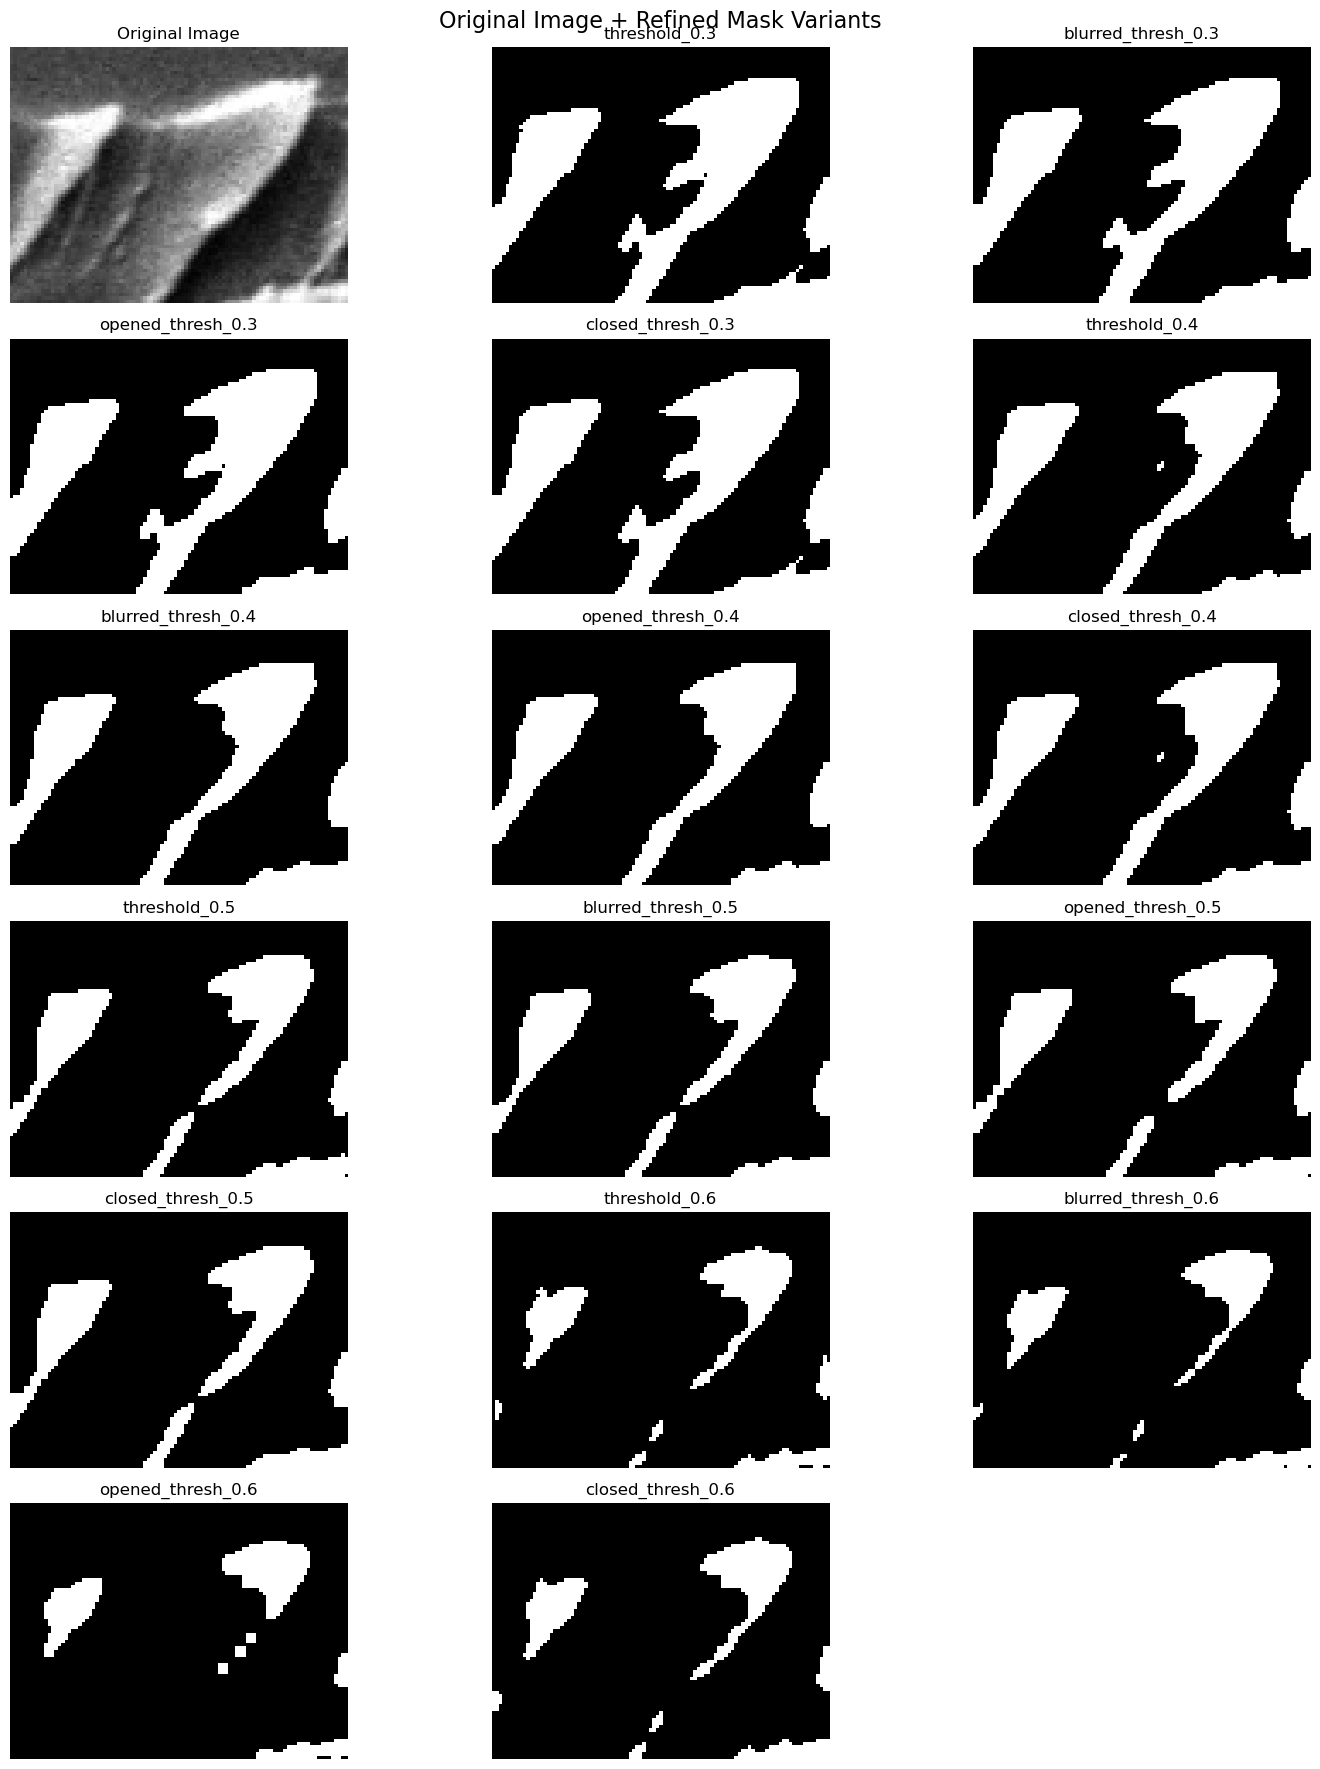

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


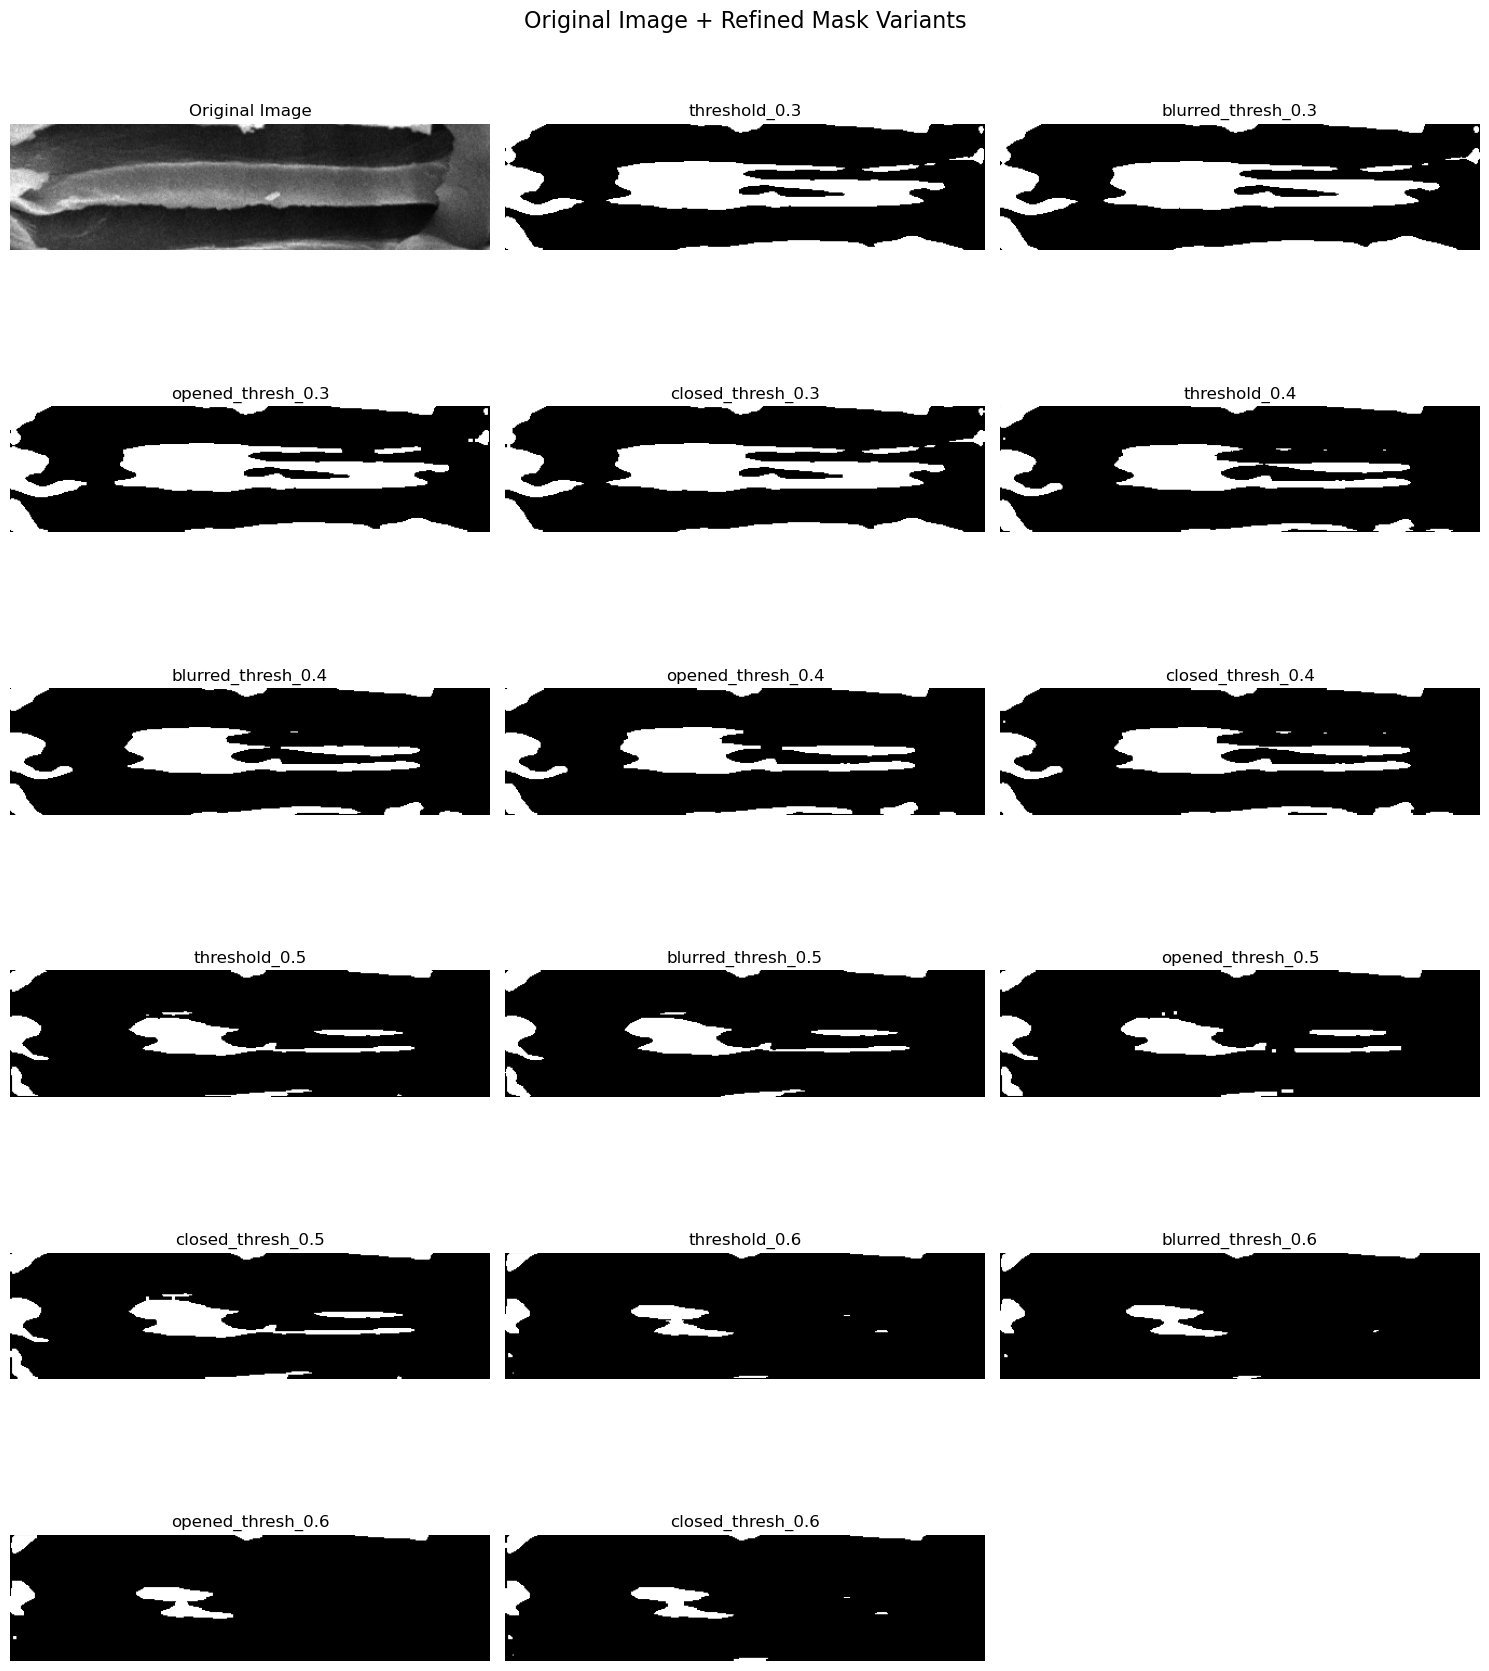

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


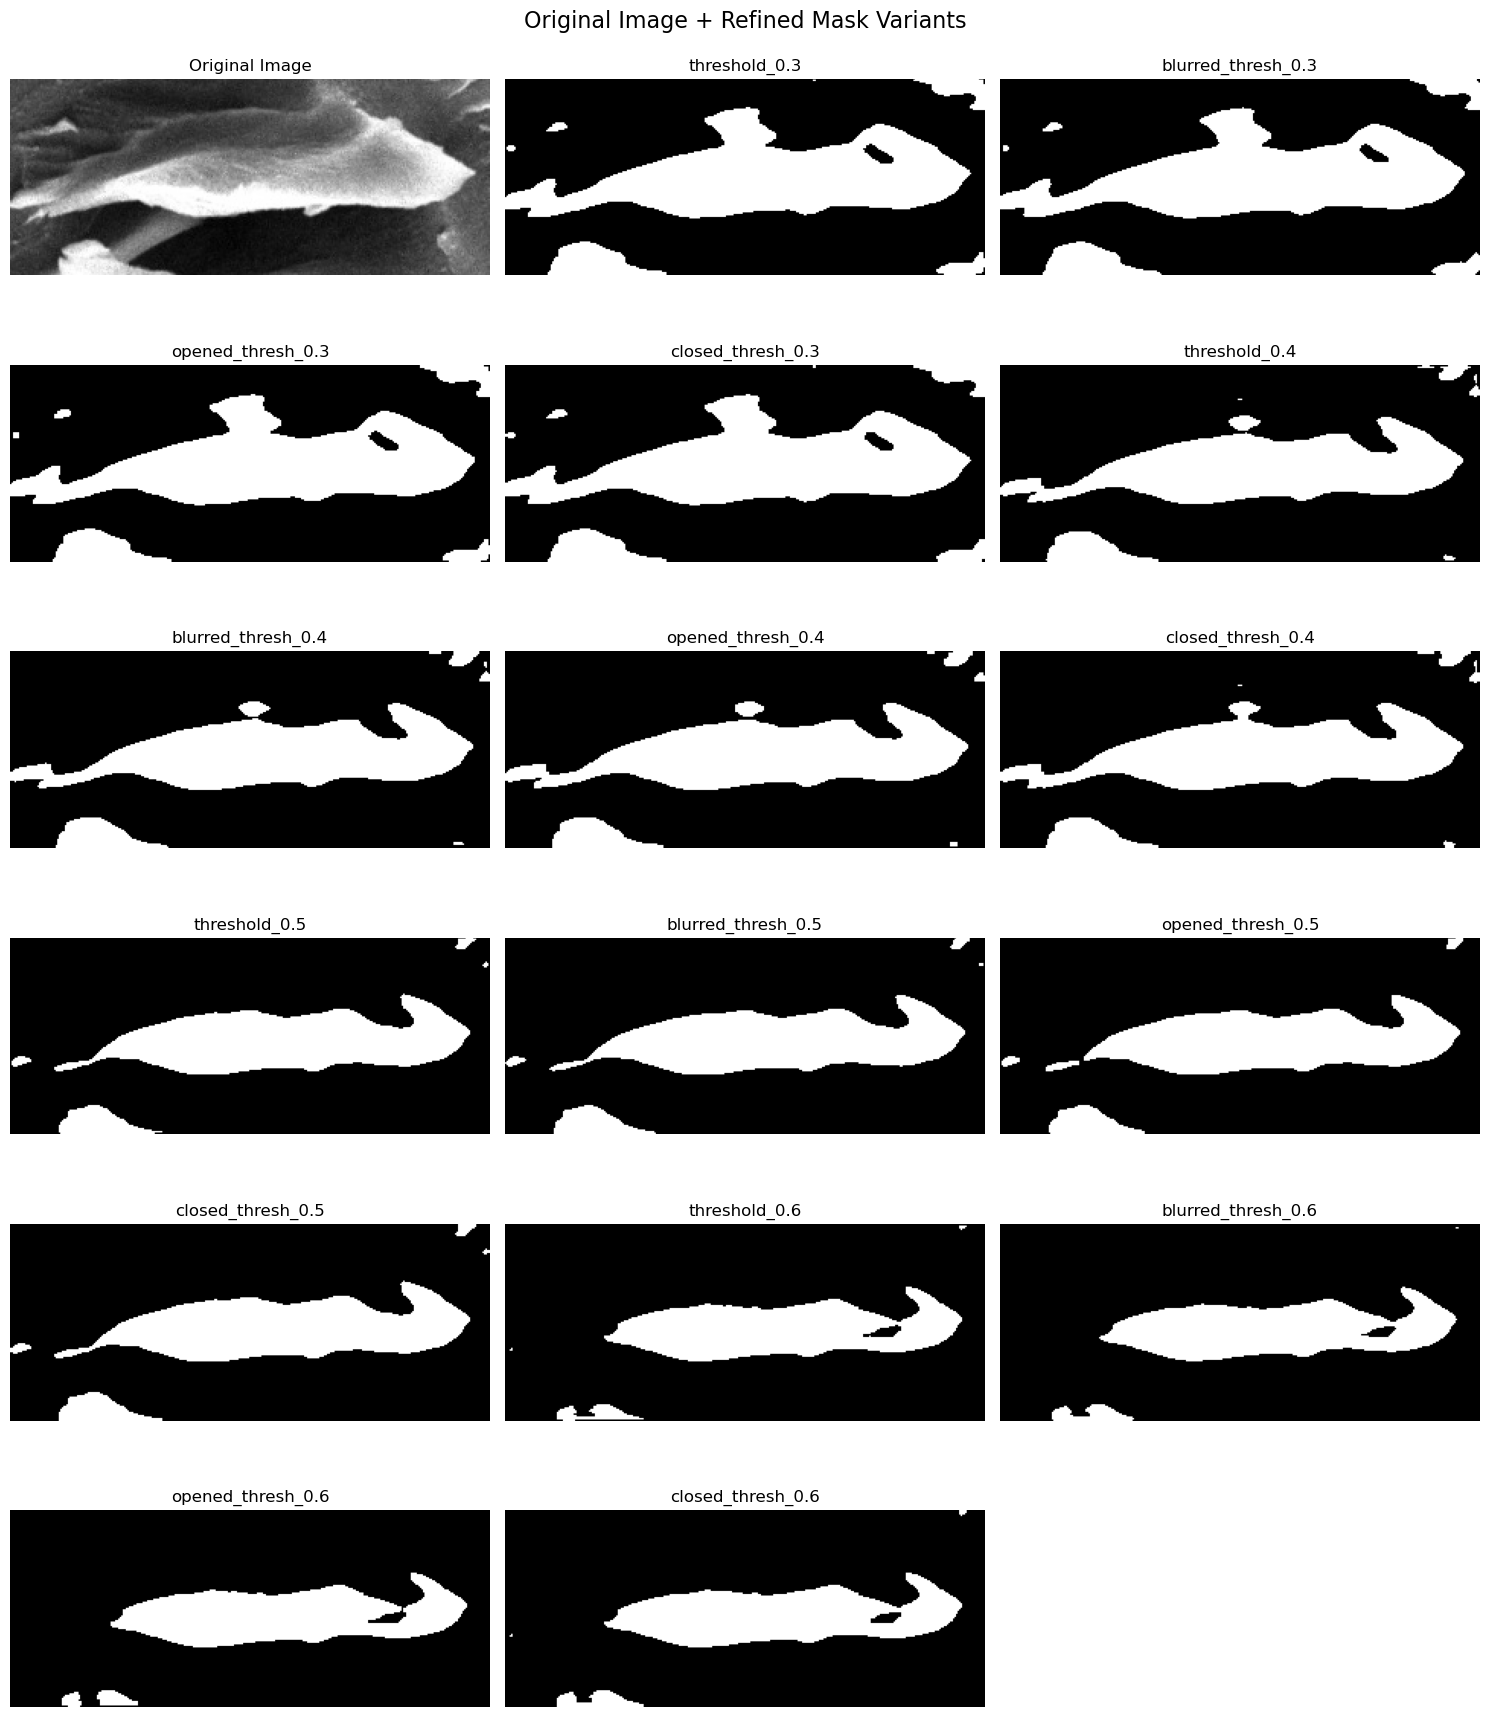

In [41]:
# Run on one file
for fname in os.listdir(image_dir)[2:6]:
    image_path = os.path.join(image_dir, fname)  # Replace with real filename
    soft_mask = predict_soft_mask(image_path, model)

    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Refine mask using several methods
    refined = refine_masks(soft_mask)
    n = len(refined)

    # Add one extra plot for the original image
    total_plots = n + 1
    plt.figure(figsize=(15, 3 * ((total_plots + 2) // 3)))

    # Plot original image first
    plt.subplot((total_plots + 2) // 3, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Plot all refined masks
    for i, (name, mask) in enumerate(refined.items()):
        plt.subplot((total_plots + 2) // 3, 3, i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(name)
        plt.axis('off')

    plt.suptitle("Original Image + Refined Mask Variants", fontsize=16)
    plt.tight_layout()
    plt.show()
